In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%pwd

'/home/ardigen/Documents/doktor_trans/bertrand/notebooks'

In [3]:
bertrand_results_mask = pd.read_csv('../../results/bertrand_with_outliers_filtering.csv')
bertrand_results_nomask = pd.read_csv('../../results/bertrand_wo_outliers_filtering.csv')

In [91]:
bertrand_results_mask['mask'] = True
bertrand_results_nomask['mask'] = False

In [92]:
bertrand_results_df = pd.concat([bertrand_results_mask, bertrand_results_nomask])

In [93]:
bertrand_results_df.head()

,rocs,n,peptide,cv_seed,dataset,subset,mask
0,0.588435,48,CTELKLSDY,42,dataset_42,test,True
1,0.597031,176,EIYKRWII,42,dataset_42,test,True
2,0.616156,266,FRCPRRFCF,42,dataset_42,test,True
3,0.800000,2,GEIYKRWII,42,dataset_42,test,True
4,0.727876,156,IPSINVHHY,42,dataset_42,test,True


In [94]:
nettcr_results_df = pd.read_csv('../../results/nettcr.csv')
ergo_results_df = pd.read_csv('../../results/ergo.csv')

In [95]:
nettcr_results_df = nettcr_results_df.rename(columns={'ds_seed': 'dataset', 'set': 'subset' })
nettcr_results_df.dataset = 'dataset_' + nettcr_results_df.dataset.astype(str)
nettcr_results_df.n = nettcr_results_df.n.astype(int)

In [96]:
ergo_results_df = ergo_results_df.rename(columns={'ds_seed': 'dataset', 'set': 'subset' })
ergo_results_df.dataset = 'dataset_' + ergo_results_df.dataset.astype(str)
ergo_results_df.n = ergo_results_df.n.astype(int)

In [97]:
ergo_results_df.head()

,rocs,n,peptide,cv_seed,dataset,mask,subset
0,0.471301,244,CTELKLSDY,42,dataset_42,False,test
1,0.526488,886,EIYKRWII,42,dataset_42,False,test
2,0.590462,1330,FRCPRRFCF,42,dataset_42,False,test
3,0.600000,12,GEIYKRWII,42,dataset_42,False,test
4,0.656535,783,IPSINVHHY,42,dataset_42,False,test


In [98]:
for dataset in ['dataset_42', 'dataset_43', 'dataset_44']:
    for cv_seed in range(42, 63):
        for mask in [True, False]:
            for subset in ['test', 'cancer']:
                r1 = bertrand_results_df[
                    (bertrand_results_df.dataset == dataset) & 
                    (bertrand_results_df.cv_seed == cv_seed) & 
                    (bertrand_results_df['mask'] == mask)  & 
                    (bertrand_results_df['subset'] == subset)
                ]

                r2 = nettcr_results_df[
                    (nettcr_results_df.dataset == dataset) & 
                    (nettcr_results_df.cv_seed == cv_seed) & 
                    (nettcr_results_df['mask'] == mask)  & 
                    (nettcr_results_df['subset'] == subset)
                ]
                r3 = ergo_results_df[
                    (ergo_results_df.dataset == dataset) & 
                    (ergo_results_df.cv_seed == cv_seed) & 
                    (ergo_results_df['mask'] == mask)  & 
                    (ergo_results_df['subset'] == subset)
                ]
            if len(r1) != len(r2) or len(r1) != len(r3) or (np.unique(r1.peptide) != np.unique(r2.peptide)).all() or (np.unique(r1.peptide) != np.unique(r3.peptide)).all():
                raise Exception()

In [99]:
bertrand_results_df.loc[:, 'model'] = 'BERTrand' 
ergo_results_df.loc[:, 'model'] = 'ERGO' 
nettcr_results_df.loc[:, 'model'] = 'NetTCR2.0' 

In [100]:
results_df = pd.concat([bertrand_results_df, ergo_results_df, nettcr_results_df])

In [101]:
results_df.loc[:, 'subset'] = results_df['subset'].map({'test': 'Cross validation test set', 'cancer': 'Independent cancer set'})
results_df.loc[:, 'mask'] = results_df['mask'].map({False: 'Basic filtering', True: 'Easy negatives filtering'})

In [102]:
results_df.head(2)

,rocs,n,peptide,cv_seed,dataset,subset,mask,model
0,0.588435,48,CTELKLSDY,42,dataset_42,Cross validation test set,Easy negatives filtering,BERTrand
1,0.597031,176,EIYKRWII,42,dataset_42,Cross validation test set,Easy negatives filtering,BERTrand


In [103]:
results_df[results_df.n >= 5].groupby(['model', 'subset', 'mask']).rocs.agg('mean').unstack()

mask                                 Basic filtering  Easy negatives filtering
model     subset                                                              
BERTrand  Cross validation test set         0.681255                  0.681255
          Independent cancer set            0.719264                  0.719264
ERGO      Cross validation test set         0.654468                  0.577079
          Independent cancer set            0.668119                  0.586522
NetTCR2.0 Cross validation test set         0.629726                  0.569234
          Independent cancer set            0.645300                  0.578768

In [107]:
results_df_agg = results_df[results_df.n >= 5].groupby(['model', 
                                                        'subset',
                                                        'mask',
                                                        'dataset', 
                                                        'cv_seed']).rocs.agg(['mean', 'std']).reset_index()

In [108]:
results_df_agg.rename(columns={'mean': 'roc', 'std': 'roc_std'}, inplace=True)

In [1]:
# Data for cancer peptides plot
pep_res_df = bertrand_results_df[(bertrand_results_df['mask'] == True) &
                                 (bertrand_results_df['subset'] == 'cancer') & 
                                 (bertrand_results_df['n'] >= 5)
                                ].copy()
# Extract info about peptide clusters
df_1 = pd.read_csv('../../results/negative_decoys/datasets/dataset_42.csv.gz')
pep_to_cluster = df_1.groupby('peptide_seq').peptide_cluster.agg('first')
pep_res_df.loc[:, 'peptide_cluster'] = pep_to_cluster.loc[pep_res_df.peptide].values
n_by_cluster = pep_res_df.groupby('peptide').agg('first').groupby('peptide_cluster').n.sum()
pep_res_df.loc[:, 'peptide_cluster_n'] = n_by_cluster.loc[pep_res_df.peptide_cluster].values
pep_res_df.sort_values(['peptide_cluster_n', 'n'], ascending=[False, False], inplace=True)
pep_res_df.loc[:, 'Peptide'] = pep_res_df.peptide + ' (n=' + pep_res_df.n.astype(str) + ')'# + pep_res_df.peptide_cluster
pep_res_df.loc[:, 'AUROC'] = pep_res_df.rocs
peptide_order = pep_res_df.groupby('peptide').n.agg('first').sort_values(ascending=False)

N = 30
pep_res_df_head = pep_res_df[pep_res_df.peptide.isin(peptide_order.head(N).index)]

pep_res_mean = pep_res_df_head.groupby('Peptide', sort=False).agg({
    'AUROC': ['mean', 'std'],
    'peptide_cluster': 'first',
})

cancer_means = pep_res_mean.AUROC['mean']
cancer_stds = pep_res_mean.AUROC['std']
total_mean_std = pep_res_df.groupby(['cv_seed', 'dataset']).rocs.agg(['mean', 'std']).mean(axis=0)
cancer_means.loc['TOTAL'] = total_mean_std['mean']
cancer_stds.loc['TOTAL'] = total_mean_std['std']

NameError: name 'bertrand_results_df' is not defined

In [85]:
def plot_peptides(ax):
    """
    plots per-peptide vertical barplot - subplot E
    """
    ax.barh(cancer_means.index[-1], cancer_means.iloc[-1],  xerr=cancer_stds.iloc[-1], capsize=5, color='#53A40D',height=0.75)
    ax.barh(cancer_means.index[::-1][1:], cancer_means[::-1][1:],  xerr=cancer_stds[::-1][1:], capsize=3, color='#1F77B4', height=0.75)
    ax.vlines(0.5, -1, N+1, color='red', linestyle='--')
    ax.set_xlim(0.2, 1.0)

In [ ]:
def plot_benchmarks(x, y, yerr, **kwargs):
    """
    plots 1 barplot - subplots A, B, C, D
    """
    ax = plt.gca()
    data = kwargs.pop("data")
    kwargs.pop('color')
    sns.barplot(data=data, x=x, y=y, ax=ax, capsize=0.1, ci='sd', **kwargs,
                order=['NetTCR2.0', 'ERGO', 'BERTrand'], 
                palette=['#EF553B', '#1F77B4', '#53A40D'])
    auroc_mean = data.groupby('model')[y].agg('mean')
    auroc_mean = auroc_mean.loc[['NetTCR2.0', 'ERGO', 'BERTrand']]
    for i, roc in enumerate(auroc_mean):
        text  = '%.2f' % roc
        ax.text(i, 0.3,  text, color='white', fontweight='bold', fontsize=15, ha='center', va='center')
    ax.hlines(0.5, -0.5, 2.5, color='red', linestyle='--')

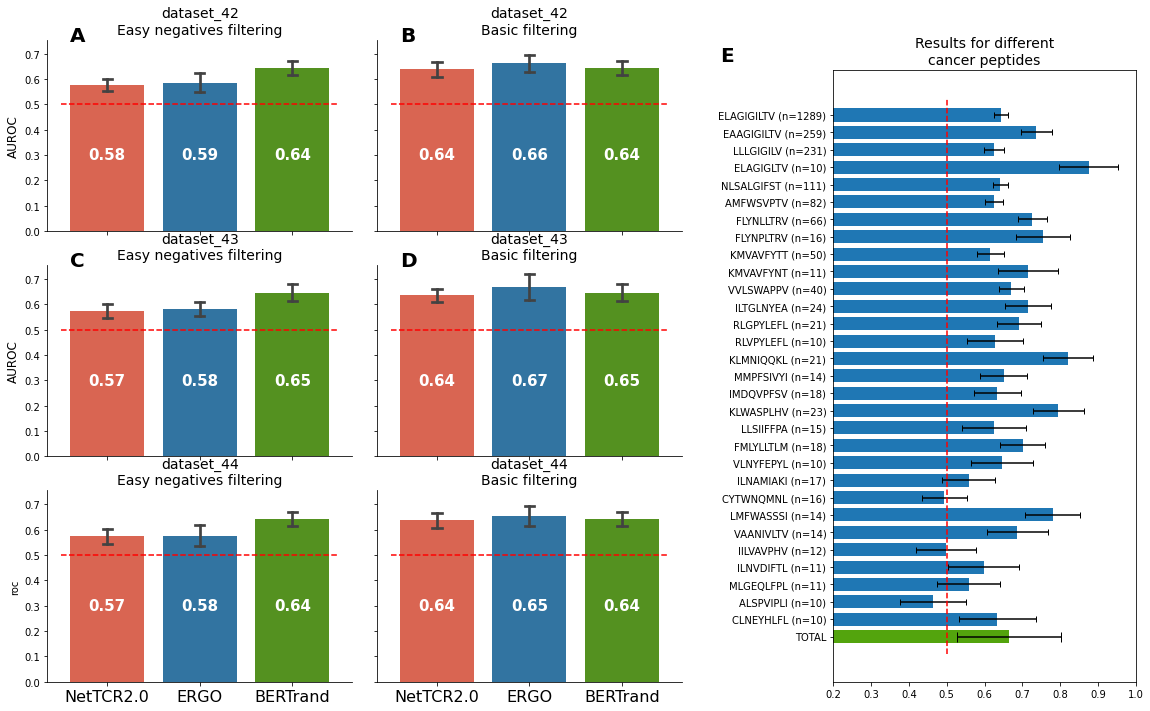

In [86]:

        

g = sns.FacetGrid(results_df_agg, col="mask", row="dataset", col_order=['Easy negatives filtering', 'Basic filtering'], )
g.map_dataframe(errplot, "model", "roc", "roc_std")

g.set_titles(template="{row_name}\n{col_name}", size=14) # {row_name}\n{col_name}
[plt.setp(ax.get_xticklabels(), rotation=0, fontsize=16) for ax in g.axes.flat]
[ax.set_xlabel('') for ax in g.axes.flat]
g.axes[0, 0].set_ylabel('AUROC', fontsize=12)
g.axes[1, 0].set_ylabel('AUROC', fontsize=12)



for ax, letter in zip(g.axes.flat, ["A","B", "C","D"]):
    ax.text(-0.4, 0.75 ,letter, fontweight="bold", fontsize=20)


g.figure.subplots_adjust(bottom=0.07, left=0.07, right=0.7)



# g.figure.subplots_adjust()
ax = g.figure.add_axes([0.85, 0.07, 0.3, 0.85], label='axis1')
ax.text(-0.1, 33.1, "E",fontweight="bold", fontsize=20)

plot_barh(ax)
ax.set_title('Results for different\ncancer peptides', fontsize=14)
g.figure.set_size_inches(14, 10)
# from matplotlib.transforms import Bbox
# g.figure.savefig('comparison.png', bbox_inches="tight")

plt.savefig('comparison.eps', format='eps', bbox_inches="tight")
